In [5]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar")

Skipping, found downloaded files in "./multiclassimagedatasetairplanecar" (use force=True to force download)


In [6]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [7]:
import os
import os.path as osp
import numpy as np
from PIL import Image

def load_data(dir):
    images = []
    labels = []
    for category in os.listdir(dir):
        for image_file in os.listdir(osp.join(dir, category)):
            img = Image.open(osp.join(dir, category, image_file))
            # resize all images to the same width and height
            img = img.resize((128, 128))
            # some images in this dataset have 4 channels (RGBA)
            # the "convert" method can handle those
            img = img.convert("RGB")
            # convert from PIL to numpy array with float values between 0 and 1
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(category)  # using the folder name as the label
    # X is of shape number_of_samples, 128, 128, 3
    X = np.array(images)
    return X, np.array(labels)


In [8]:
import os
print(os.listdir())





['.config', 'multiclassimagedatasetairplanecar', 'sample_data']


In [9]:
# Adjust the paths based on the directory structure
X_train, y_train = load_data("multiclassimagedatasetairplanecar/Dataset/train")
X_test, y_test = load_data("multiclassimagedatasetairplanecar/Dataset/test")

# Update labels where necessary (e.g., changing 'ship' to 'ships')
y_train[y_train == 'ship'] = 'ships'

# Print the shapes of the arrays to verify the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(3000, 128, 128, 3) (3000,)
(582, 128, 128, 3) (582,)


In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform both training and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the encoded labels to one-hot encoding format
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Display the shape to confirm the transformation
print(y_train_one_hot.shape, y_test_one_hot.shape)



(3000, 3) (582, 3)


(3000, 128, 128, 3) (3000, 3)
(582, 128, 128, 3) (582, 3)


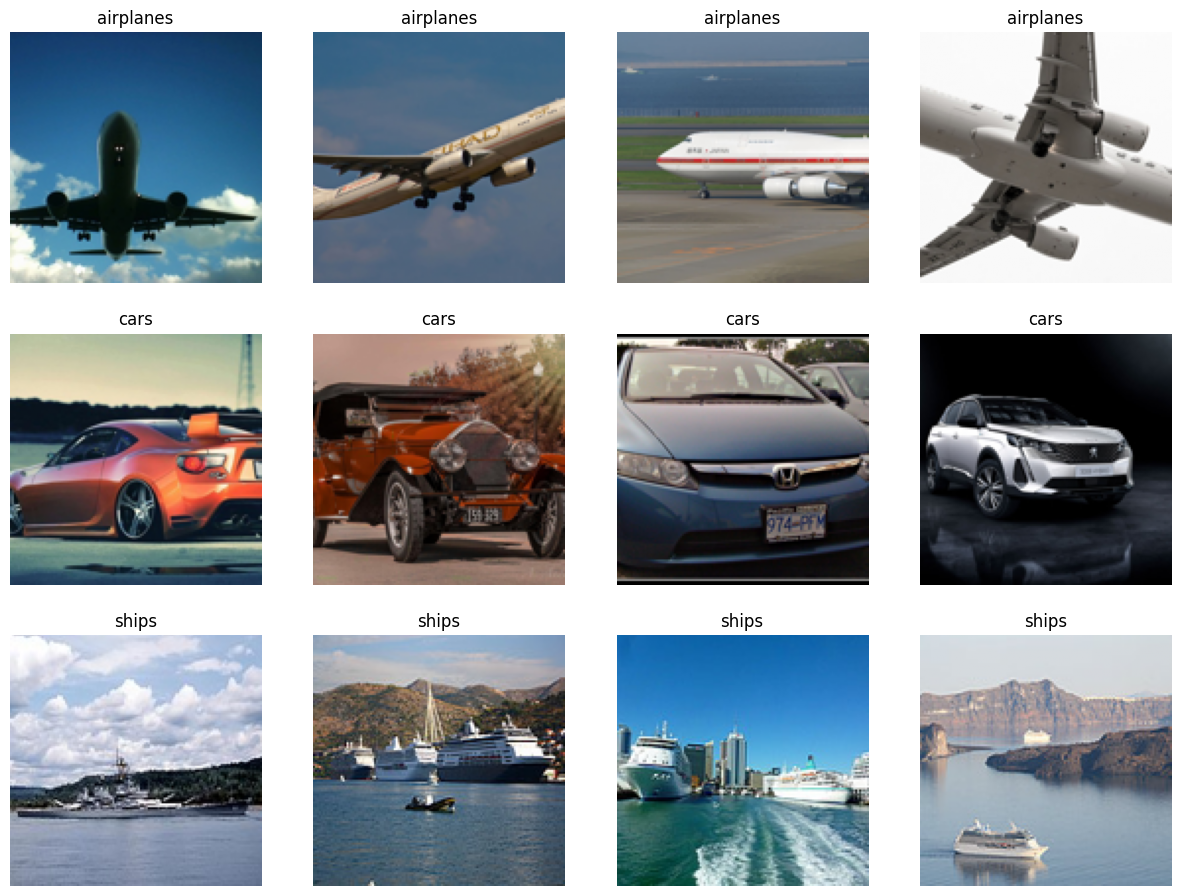

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the data (using the correct path for the dataset)
def load_data(dir):
    images = []
    labels = []
    for category in os.listdir(dir):
        for image_file in os.listdir(os.path.join(dir, category)):
            img = Image.open(os.path.join(dir, category, image_file))
            # Resize all images to the same width and height
            img = img.resize((128, 128))
            # Convert RGBA to RGB if necessary
            img = img.convert("RGB")
            # Convert from PIL to numpy array with float values between 0 and 1
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(category)  # Using the folder name as the label
    # X is of shape (number_of_samples, 128, 128, 3)
    X = np.array(images)
    return X, np.array(labels)

# Update the paths to match the location of the 'train' and 'test' folders
X_train, y_train = load_data("multiclassimagedatasetairplanecar/Dataset/train")
X_test, y_test = load_data("multiclassimagedatasetairplanecar/Dataset/test")

# Replace 'ship' with 'ships' in the labels to ensure consistency
y_train[y_train == 'ship'] = 'ships'
y_test[y_test == 'ship'] = 'ships'

# Encode the labels to integers
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Check the shape of the data to verify it was processed correctly
print(X_train.shape, y_train_one_hot.shape)
print(X_test.shape, y_test_one_hot.shape)

# Data exploration - Display a mix of images and their labels
plt.figure(figsize=(15, 15))

# Get unique categories (labels)
categories = np.unique(y_train)

# Loop through categories and display random images for each category
for i, category in enumerate(categories):
    category_indices = np.where(y_train == category)[0]  # Find indices for this category
    selected_indices = np.random.choice(category_indices, 4, replace=False)  # Pick 4 random images

    for j, idx in enumerate(selected_indices):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.axis('off')
        plt.imshow(X_train[idx])  # Display image
        plt.title(category)  # Set the title to the category label

plt.show()


In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model
model = models.Sequential()

# Add convolutional layers with ReLU activation
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling to reduce size

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers before passing to fully connected layers
model.add(layers.Flatten())

# Add fully connected (dense) layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting

# Output layer with softmax activation for multiclass classification
model.add(layers.Dense(3, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation data, only rescale the images (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Apply the data generators to your training and validation sets
train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
val_generator = val_datagen.flow(X_test, y_test_one_hot, batch_size=32)

# Early stopping callback to stop training when validation loss is not improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Keep the same number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

# Generate predictions on test data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3590 - loss: 1.0957 - val_accuracy: 0.5619 - val_loss: 0.9752
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5331 - loss: 0.9333 - val_accuracy: 0.6340 - val_loss: 0.8236
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5933 - loss: 0.8413 - val_accuracy: 0.5773 - val_loss: 0.9070
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6043 - loss: 0.8546 - val_accuracy: 0.6735 - val_loss: 0.7606
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6700 - loss: 0.7619 - val_accuracy: 0.6821 - val_loss: 0.7579
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6681 - loss: 0.7482 - val_accuracy: 0.7113 - val_loss: 0.6806
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6766 - loss: 0.7471 - val_accuracy: 0.7045 - val_loss: 0.6685
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6950 - loss: 0.6896 - val_accuracy: 0.6959 - val_loss: 0.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the CNN
model = Sequential()

# Add the first Conv2D layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # same input shape used earlier
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second Conv2D layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the third Conv2D layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a Dense layer for fully connected output
model.add(Dense(128, activation='relu'))

# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))  # Three classes for multi-class classification

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Fit the model (ensure you're using the same training/validation data as before)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import numpy as np
import cv2
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

# Assuming you have already loaded your trained model
# model = load_model('path_to_your_model')

# Assuming you have X_test and y_test_one_hot already defined in your script

# Resize the test set images to (128, 128, 3)
X_test_resized = np.array([cv2.resize(image, (128, 128)) for image in X_test])

# Ensure that the images have the right number of channels (3 for RGB)
X_test_resized = np.stack([image if image.ndim == 3 else np.stack([image]*3, axis=-1) for image in X_test_resized])

# Normalize the images (optional, but recommended)
X_test_resized = X_test_resized / 255.0

# Make predictions on the resized test set
y_pred = model.predict(X_test_resized)

# Convert the predictions from one-hot encoding to labels (integer values)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the true labels from one-hot encoding to labels (integer values)
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Print the classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=['airplane', 'car', 'ship'])
print(report)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step
              precision    recall  f1-score   support

    airplane       0.24      0.11      0.15       189
         car       0.00      0.00      0.00       193
        ship       0.37      0.92      0.53       200

    accuracy                           0.35       582
   macro avg       0.20      0.34      0.22       582
weighted avg       0.21      0.35      0.23       582



In [33]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session

clear_session()

# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling=None)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(inception_model.output)

# Add a fully connected (dense) layer for classification
x = Dense(128, activation='relu')(x)

# Add a softmax layer for multi-class classification (3 classes)
predictions = Dense(3, activation='softmax')(x)

# Full model
model = Model(inputs=inception_model.input, outputs=predictions)

# Freeze all InceptionV3 layers
for layer in inception_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to confirm everything is in place
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [34]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming `y_test_labels` are your true labels and `y_pred_labels` are the predicted labels from your model

# Print the classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=['airplane', 'car', 'ship']))


              precision    recall  f1-score   support

    airplane       0.24      0.11      0.15       189
         car       0.00      0.00      0.00       193
        ship       0.37      0.92      0.53       200

    accuracy                           0.35       582
   macro avg       0.20      0.34      0.22       582
weighted avg       0.21      0.35      0.23       582



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1: liner with a confidence of 0.71
2: dock with a confidence of 0.22
3: drilling_platform with a confidence of 0.01
Predicted label: ship with confidence: 0.71


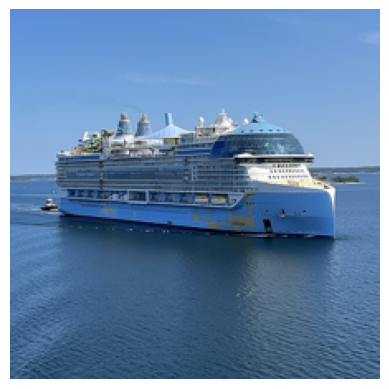

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Load the ResNet50 model pre-trained on ImageNet
model = ResNet50(weights='imagenet')

# URL of the image you want to classify
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Icon_of_the_Seas.jpg/640px-Icon_of_the_Seas.jpg'

# Download the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Preprocess the image for ResNet50
img = img.resize((224, 224))  # Resize image to 224x224
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)

# Get predictions
predictions = model.predict(img_array)

# Decode predictions
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Print the decoded predictions
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i+1}: {label} with a confidence of {score:.2f}")

# Get the top prediction and the associated label
top_prediction = decoded_predictions[0]
predicted_label = top_prediction[1]

# Map specific labels like "liner" or "cargo_ship" to "ship"
if predicted_label in ['liner', 'cargo_ship', 'cruise_ship']:
    predicted_label = 'ship'

# Display the predicted label
print(f"Predicted label: {predicted_label} with confidence: {top_prediction[2]:.2f}")

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()

